# P3: Limpando dados do OpenStreetMap

* Lieby Cardoso
                                                
* Região selecionada para o projeto: 
Selecionei Belo Horizonte, MG, Brasil por ser a cidade em que moro e acredito ser interessante conhecer alguns pontos locais, também o domínio de informações prévias sobre a região podem ajudar na ánálise das informações cadastradas. 

Região: http://www.openstreetmap.org/relation/368782

### Conteúdo

1.	Métodos e ferramentas
2.	Problemas encontrados no mapa
3.  Visão geral dos dados
4.  Outras Ideias sobre os Dados
5.  Conclusão
6.  Referências

### 1.	Métodos e ferramentas

Descritivo dos métodos e ferramentas utilizados neste trabalho https://github.com/liebycardoso/OpenStreetMap/blob/master/Metodos_ferramentas.pdf

### 2.	Problemas encontrados no mapa

** Localização da identificação do tipo de rua **

Diferente dos exercícios realizados, onde o mapa era da cidade de Chicago e o tipo da rua podia ser identificado pela última palavra do nome, no mapa de Belo Horizonte, o nome da rua é composto pelo tipo, abreviado ou não, seguido pelo nome. Para atender esta particularidade da nomenclatura brasileira, a variável street_type_re foi reformulada para trabalhar com a primeira palavra da frase. A alteração consistiu na inclusão do caractere ^ , que corresponde sempre com o início da string e exclusão do caractere $, que corresponde com o final da string.

Trecho do código:

In [ ]:
 street_type_re = re.compile(r'^\b(?u)\w\S+\.?', re.IGNORECASE)

** Caracteres especiais **

Ao iniciar a auditoria dos dados, imprimi em tela o nome de algumas ruas da amostra e a lógica do programa não foi seguida em alguns casos porque existiam ruas com caracteres especiais como acentos agudos (‘), circunflexos (^), til (~) e cedilha (ç). 
No cabeçalho do script foi incluído o comando # -*- coding: utf-8 -*- para possibilitar a manipulação destes caracteres com a codificação Unicode utf-8.

Mesmo fazendo essa inclusão, foi necessário acrescentar a letra ‘u’ antes de strings que foram usadas para comparação. Um exemplo é a palavra “Praça” incluída manualmente como string comparativa da variável expected, quando feita a comparação de “Praça” digitado com Praça retornando de uma variável, a comparação não era bem sucedida, neste caso a palavra “Praça” digitada foi substituída por u”Praça” para ser reconhecida como contendo caractere especial.

Outro tratamento foi incluir a codificação (?u)\w para todos os caracteres Unicode no re.compile.

Trecho do código:

In [22]:
# -*- coding: utf-8 -*-
expected_street = ["Rua", "Avenida", "Beco", "Rodovia", "Expressa", u"Praça", "Anel", "Alameda"]

** Vias sem tipo definido e mapeamento de tipos**

Algumas vias não tinham o seu tipo definido, como por exemplo, avenida, alameda, beco e etc.. Quando a via não tinha o tipo compatível com os cadastrados no array expected, nem no dicionário mapping_street, atribuí o prefixo “Rua” para todas elas. 

- Método: update_street_type(name, mapping):
- Script: audit_map_bh

Vias sem tipo:
- Montes Claros => Rua Montes Claros
- Paracatu => Rua Paracatu
- Francisco Deslandes => Rua Francisco Deslandes
- Riachuelo => Rua Riachuelo

Vias com tipo mapeado:
- Av São Lucas => Avenida São Lucas
- Anél Rodoviário => Anel Rodoviário
- Avendia Dom Pedro II => Avenida Dom Pedro II
- Alamedas das Princesas => Alameda Das Princesas
- Eua Conceição Aparecida => Rua Conceição Aparecida
- Pc Nossa Senhora do Rosário => Praça Nossa Senhora Do Rosário
- R. A => Rua A
- R.B => Rua B

** Títulos abreviados **

Após corrigir a abreviatura do nome das ruas, percebi que algumas ruas estavam com o título da pessoa que deu nome à rua abreviado. Em BH todos os casos eram Prof. no lugar de Professor.

- Método: update_street_title(name, mapping): 
- Script: audit_map_bh

Exemplo:
- Rua Prof. Melchíades da Costa Lage => Rua Professor Melchíades Da Costa Lage 

** Nome da cidade **

O mapa da região de Belo Horizonte contém também informações sobre a região metropolitana, por esta razão a chave addr:city recebeu um tratamento para uniformizar os nomes, uma vez que, eram apresentados erros de grafia e o nome da cidade composto com o nome do estado.

- Método: update_city(name, mapping): 
- Script: audit_map_bh

Exemplo:
- Beo horizonte => Belo Horizonte
- Belo Horizonte – MG => Belo Horizonte
- Belo Horizonte MG Brazil => Belo Horizonte

** Código postal **

O código postal é um atributo importante do endereço e pela contagem de valores, percebi que havia um bom volume de dados preenchidos, padronizei o campo como sendo uma sequencia de 8 números sem o caractere "-".

- Método: update_code_postal (name, mapping): 
- Script: audit_map_bh

## 3. Visão geral dos dados

###  Representação dos dados OSM 

Os dados estão organizados em uma estrutura de elementos do mapa que representam o objeto e seu valor associado. Tipos encontrados:

- node: um nó é informações de um par de coordenadas, sendo latitude e longitude;
- way : uma lista de nós (nodes);

Apesar do OpenStreetMap ter mais dois tipos de elementos abaixo listado, eles não foram considerados neste projeto.
- area: representa uma área limitada, por exemplo, uma praça;
- relation: pode ser um conjunto de nodes, ways e relation relacionados.

###  Importação dos dados para pesquisa 

O arquivo mapbh.json, gerado após análise dos dados OSM para Belo Horizonte, foi importado para o MongoDB através da linha de comando:

* => mongoimport -h 127.0.0.1:27017 --db openstreetmap --collection mapbh --file C:/Nanodegree/MongoDb/Trab_final/mapbh.json  


Os dados no MongoDB serão acessados e manipulados através da biblioteca pymongo.

In [2]:
import pprint
import matplotlib.pyplot as plt
%matplotlib inline
import pymongo
from bson import SON
from pymongo import MongoClient
client=MongoClient('localhost:27017')
db=client.openstreetmap

Os dados importados fazem parte de uma coleção nomeada mapbh (--collection mapbh). 
Verificando se o nome foi criado corretamente: 

In [29]:
db.collection_names()

[u'mapbh']

###  Conhecendo os dados 

** 3.1. Estatística dos dados **

Um resumo com o total de documentos e tamanho do dados. 

In [19]:
stats_mapbh = db.command("dbstats")

In [29]:
print "Tamanho da colecao: ", stats_mapbh["dataSize"]
print "Total de documentos: ",  stats_mapbh["objects"]
print "Total de indices: " , stats_mapbh["indexes"]

Tamanho da colecao:  112706375.0
Total de documentos:  466927
Total de indices:  1


** 3.2. Número de documentos com o tipo "node": **

In [38]:
db.mapbh.find({"type":"node"}).count() 

408052

** 3.3. Número de documentos com o tipo "way": **

In [39]:
db.mapbh.find({"type":"way"}).count()

58875

** 3.4. Documentos com tipo diferente de "way" e "node": **

O total de node e way é (408.052 + 58.875) 466.927, um pouco diferente dos 466.990 listados no db.mapbh.find().count(). Vou listar esses registros que não são way, nem node para identificar o problema, visto que na função shape_element eu fitrei os registros por tags que contivessem as strings "node" e "way".

In [70]:
list(db.mapbh.find({"type":{"$nin":["way","node"]}}))

[]

Percorrendo os registros acima é possível perceber que eles tem uma tag "type", como não foi implementada nenhum método que filtrasse esse tipo de situação, o valor desta tag própria substituiu o da tag "type" que deveria ter o tipo do atributo tag.

Estes registros que foram comprometidos pela lógica da programação, serão excluídos da coleção. Uma correção possível na função shape_element é atribuir o valor de node['type'] = element.tag ao fim processo e não no início, como foi implementado.

In [47]:
db.mapbh.delete_many({"type":{"$nin":["way","node"]}})

Será que agora todos os registros são do tipo node ou way? Vamos conferir se o total de documentos na coleção é igual ao total de registros com way + node.

In [50]:
db.mapbh.find().count() == db.mapbh.find({"type":{"$in":["way","node"]}}).count()

True

A comparação retornou True e os registros foram excluídos corretamente.

** 3.5. Tamanho dos arquivos OSM e JSON **

- mapbh.OSM => 93.432 kb
- mapbh.json => 136.726 kb
- Coleção mapbh => 112.706 kb

** 3.6. Usuários contribuintes com OSM de BH **

Total de usuários únicos que contribuiram com o mapa de BH:

In [4]:
print "Total de usuários: " , len(db.mapbh.distinct("created.uid"))

Total de usuários:  593


Nome e o total de contribuições do usuário que mais contribuiu para o OSM de BH:

In [32]:
pipeline=[
            {"$match": {"type": "node"}},
            {"$group": {"_id": {"Cod":"$created.uid", "user":"$created.user"}, "total": {"$sum": 1}}},
            {"$sort" : {"total" : -1}},
            {"$limit": 1}
          ]

list(db.mapbh.aggregate(pipeline))

[{u'_id': {u'Cod': u'397143', u'user': u'Vitor Dias'}, u'total': 128024}]

Total de contribuições dos outros usuários:

In [9]:
pipeline=[
            {"$match": {"type": "node", "created.uid" :{"$ne": "397143"}}},
            {"$group": {"_id": "TotalContibuicoesUsuarios", "total": {"$sum": 1}}},
            {"$sort" : {"total" : -1}}
          ]

list(db.mapbh.aggregate(pipeline))

[{u'_id': u'TotalContibuicoesUsuarios', u'total': 280028}]

O usuário Vitor Dias é responsável por 32% da contribuição dos dados.

## 4. Outras Ideias sobre os Dados

** A capital mundial dos botecos ... será?! **

Belo Horizonte se orgulha de ser a capital mundial dos botecos. Se você já passou por aqui, provavelmente, mesmo que conheça poucas cidades, deve ter percebido que isso é verdade. Será que conseguimos ver essa informação nos dados?

In [39]:
pipeline = [{"$match": {"amenity":{"$ne": None,"$exists": 1}}},
            {"$group":{"_id":"$amenity" , "total":{"$sum":1}}},
            {"$sort" : {"total" : -1}},
            {"$limit": 10}            
           ]
            
list(db.mapbh.aggregate(pipeline))

[{u'_id': u'Restaurant', u'total': 443},
 {u'_id': u'School', u'total': 394},
 {u'_id': u'Parking', u'total': 261},
 {u'_id': u'Fuel', u'total': 260},
 {u'_id': u'Bank', u'total': 210},
 {u'_id': u'Place_Of_Worship', u'total': 208},
 {u'_id': u'Pub', u'total': 154},
 {u'_id': u'Bar', u'total': 148},
 {u'_id': u'Pharmacy', u'total': 130},
 {u'_id': u'Fast_Food', u'total': 126}]

Nenhuma surpresa, Restaurante, Pub e Bar apareçam no top 10. Temos mais Pubs e Bares que farmácias!

Já sabemos que restaurante é o tipo de instalação mais comum, agora vamos ver o tipo de culinária que cada uma oferece:

In [41]:
pipeline = [
            {"$match":{"cuisine":{"$exists":1}, "amenity":{"$exists":1}, "amenity":"Restaurant"}},
            {"$group": {"_id":"$cuisine", "total": {"$sum":1}}},
            {"$sort" : {"total" : -1}},
            {"$limit": 5}]

list(db.mapbh.aggregate(pipeline))

[{u'_id': u'Regional', u'total': 59},
 {u'_id': u'Pizza', u'total': 30},
 {u'_id': u'Italian', u'total': 20},
 {u'_id': u'Japanese', u'total': 8},
 {u'_id': u'Fish', u'total': 7}]

O resultado é bastante razoável, a região tem vários restaurantes de comida mineira (Regional) e pizzarias que é comum na maioria das cidades.

** Localizando lugares através de seu ponto geográfico **

Esta seção não tem a intenção de oferecer uma ferramenta real de pesquisa por pontos de latitude e longitude, o intuito é apenas exibir uma forma opcional de pesquisa nos dados, já que estamos analisando um mapa e a informação de localização está disponível.

A primeira coisa a fazer é criar um novo campo espelho do campo "pos" em todos os documentos da coleção em que ele existe. Pra isso, faço o update do campo usando o comando $set, como o campo não existe, o MongoDB fará a sua criação. Neste momento o campo receberá apenas a string pos.

In [81]:
db.mapbh.update_many({"pos":{"$ne": None,"$exists": 1}},
                    {"$set": {"loc": "pos"}})

Depois de criar o campo, vou transforma-lo em índice do tipo geoespacial, para isso é só informar pymongo.GEO2D.

In [66]:
db.mapbh.create_index([("loc", pymongo.GEO2D)])

u'loc_2d'

Nessa terceira etapa vou buscar todos os registros que tem o campo pos preenchido e armazenar na variável pos.
O objetivo é usar esta variável como fonte de informação na alimentação dos valores de loc, que neste momento está com a string pos como valor único.

In [106]:
pos = list(db.mapbh.find({"pos":{"$exists":1}}))

Para finalizar, percorro todos os registros da variável pos e para cada um insiro o valor de latitude e longitude onde o _id é o mesmo.

In [108]:
for item in pos:
    db.mapbh.update_one({"_id": item["_id"]},
                        {"$set": {"loc": item["pos"]}})   

Agora que o indice está criado, vou buscar por uma coordenada qualquer em uma rua bem conhecida de BH. Essa informação será passada adiante como ponto de referência na pesquisa de lugares próximos.

In [64]:
list(db.mapbh.find({"address.street" : "Avenida Do Contorno"}))[0]

{u'_id': ObjectId('58641665ed425d6e306c706e'),
 u'address': {u'housenumber': u'5771',
  u'postcode': u'30110-035',
  u'street': u'Avenida Do Contorno'},
 u'amenity': u'Pub',
 u'created': {u'changeset': u'21700331',
  u'timestamp': u'2014-04-15T00:45:03Z',
  u'uid': u'2032426',
  u'user': u'Victor Caldeira Colen',
  u'version': u'6'},
 u'id': u'320934190',
 u'loc': [-19.9398678, -43.9312457],
 u'name': u'Stadt Jever',
 u'pos': [-19.9398678, -43.9312457],
 u'source': u'Web',
 u'type': u'node',
 u'website': u'Http://Wals.Com.Br/Stadt-Jever'}

Vou pesquisar lugares próximos da coordenada [-19.93, -43.94]. Você pode utilizar o operador "$maxDistance" ou "$minDistance" para restringir a distância dos pontos que você está buscando.

In [65]:
%time db.mapbh.find({'loc': SON([('$near', [-19.93, -43.93]), ('$maxDistance', 0.001)])}).count()

Wall time: 3 ms


24

Foram encontrados 32 resultados para esta pesquisa, nada mal! E o tempo de pesquisa é muito rápido, só 3ms para percorrer a coleção com 408 mil documentos.

#### Cidades
O atributo Nome da Cidade foi auditado na fase anterior e seus valores foram mapeados. Vamos executar uma consulta que retorne o nome das cidades e total de ruas cadastradas para cada uma delas.

In [43]:
pipeline = [{"$unwind" : "$address.city"},
            {"$group": {"_id" : {"cidade":"$address.city", "rua":"$address.street"}, "ccount": {"$sum": 1}}},
            {"$group" : {"_id": "$_id.cidade", "TotalRuas" : {"$sum": "$ccount"}}},
            {"$sort" : {"TotalRuas" : -1}}
            ]

total_rua_cidades = list(db.mapbh.aggregate(pipeline))

In [44]:
pprint.pprint(total_rua_cidades)

[{u'TotalRuas': 328, u'_id': u'Belo Horizonte'},
 {u'TotalRuas': 16, u'_id': u'Betim'},
 {u'TotalRuas': 12, u'_id': u'Contagem'},
 {u'TotalRuas': 8, u'_id': u'Nova Lima'},
 {u'TotalRuas': 5, u'_id': u'Sarzedo'},
 {u'TotalRuas': 5, u'_id': u'Sabar\xe1'},
 {u'TotalRuas': 4, u'_id': u'Santa Luzia'},
 {u'TotalRuas': 2, u'_id': u'Ribeir\xe3o Das Neves'}]


Na lista de cidades o nome Belo Horizonte aparece duas vezes sendo uma delas com grafia incorreta "Belo Horizont". Para corrigir a situação no banco de dados atualizei o nome para o correto. Essa falha ocorreu porque no método update_city do script audit_map_BH eu atribuí para Belo Horizonte um tamanho de [0:13], quando deveria ter sido [0:14]. O método foi corrigido e atualizado. 

In [26]:
db.mapbh.find({"address.city":"Belo Horizont"}).count()

8

In [28]:
db.mapbh.update({"address.city":"Belo Horizont"}, 
                {"$set": {"address.city":"Belo Horizonte"}},multi=True)

C:\Program Files (x86)\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: DeprecationWarning: update is deprecated. Use replace_one, update_one or update_many instead.
  from ipykernel import kernelapp as app


{u'n': 8, u'nModified': 8, u'ok': 1, 'updatedExisting': True}

Agora que o dados estão consistentes, vamos imprimir um gráfico de pizza com a distribuição das ruas cadastradas por cidade. Existem dados cadastrados para a capital Belo Horizonte e para as cidades da região metropolitana.

([<matplotlib.patches.Wedge at 0xc517128>,
  <matplotlib.text.Text at 0xc5d2240>])

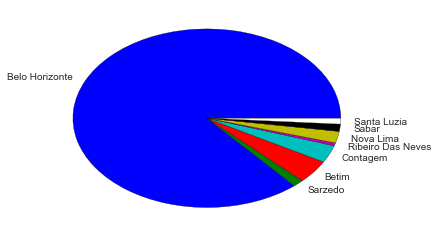

In [30]:
cidade = []
total = []
for item in total_rua_cidades:
    total.append(item["TotalRuas"])
    cidade.append(item["_id"].encode('ascii', 'ignore'))
plt.pie(x=total,labels=cidade)

### Melhoria no dados 

A falta de dados cadastrados para os pontos de interesse dificultam a utilização do OpenStreetMap. Em uma busca que fiz no site http://www.openstreetmap.org/ por locais próximos ao meu endereço, não consegui localizar os estabelecimentos que conheço. Fiz o cadastramento de um supermercado e uma veterinária, e seria interessante se esta inserção de dados  pudesse ser feito através de um app que estimulasse o cadastramento de informação enquanto você estivesse naquele local, assim como o aplicativo Waze faz, agregado a isto uma opção de reconhecimento com medalhas para os contribuintes frequentes,  estilo jogos como Pokemon Go =) . 
Orgão públicos como o ministério do turismo de Minas Gerais poderia incentivar as redes hoteleiras a cadastrarem informações sobre o seu estabelecimento e sobre os pontos interessantes próximos que um hospede pudesse utilizar durante sua estadia, isso fortaleceria o mapa e a visitação na região.

## 5. Conclusão

Uma parte significativa dos dados de Belo Horizonte não está formatada de acordo com minha expectativa, o que dificultou a obtenção de resultados com mais volume de informações, essa ausência dos atributos de algumas ruas torna este projeto sem valor estatístico e o impede de ser um reflexo das características de Belo Horizonte. A contagem de ruas com o atributo address.street cadastrados, retornou apenas 320 resultados para Belo Horizonte, demonstrando a falta de preenchimento de alguns registros para a 6º cidade mais populosa do Brasil.

Apesar deste obstáculo, o mapa atendeu ao objetivo da análise e possibilitou um bom aprendizado da manipulação de dados utilizando pymongo e MongoDB.

## 6. Referências

- wiki.openstreetmap.org/wiki/Belo_Horizonte
- wiki.openstreetmap.org/wiki/WikiProject_Brazil
- overpass-api.de/api/map?bbox=-44.3092,-20.0979,-43.6116,-19.7376
- github.com/FrankRuns/Udacity/tree/master/OpenStreetMap-Analysis/OSM_Data_Project
- github.com/ucaiado/OpenStreetMaps
- pt.slideshare.net/mbright1/using-mongodb-and-python-demo